# Clasificador de reseñas

- **Joan Pedro Bruxola**
- **Julio García Bustos**
- **Marcos Rosique Martínez**
- **Mario Soto Ramos**

In [34]:
import numpy as np
import pandas as pd
import requests
import re
import kagglehub
import os
import gc
import json

import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup
import time
from langdetect import detect, LangDetectException
import spacy
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

c:\Users\mario\Proyecto_NLP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extracción de URLs

### URLs de las películas

In [35]:
# Parámetros para la URL (puedes cambiar estos valores dinámicamente)
params = {
    "releaseYearMin": 2015,  # Año mínimo
    "releaseYearMax": 2020,  # Año máximo
    "page": 1                # Número de página
}

n = 24  # Número de películas que queremos obtener

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Realizamos la solicitud GET con los parámetros
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers, params=params)

# Comprobamos si la solicitud fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontramos todos los enlaces a las películas
    movie_links_positive = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")
    
    # Lista para almacenar los enlaces
    links_positive = []

    # Extraemos los enlaces de las primeras 24 películas y los guardamos en la lista
    for idx, link in enumerate(movie_links_positive[:n]):  # Solo las primeras 24
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            links_positive.append(full_url)  # Guardamos el enlace en la lista
            print(f"Película {idx+1}: {full_url}")
    
    # Opcional: Puedes ver todos los enlaces almacenados
    print("\nLista de enlaces almacenados:")
    print(links_positive)

else:
    print("Error al acceder a la página.")

Película 1: https://www.metacritic.com/movie/moonlight-2016/
Película 2: https://www.metacritic.com/movie/parasite/
Película 3: https://www.metacritic.com/movie/roma/
Película 4: https://www.metacritic.com/movie/manchester-by-the-sea/
Película 5: https://www.metacritic.com/movie/small-axe-lovers-rock/
Película 6: https://www.metacritic.com/movie/portrait-of-a-lady-on-fire/
Película 7: https://www.metacritic.com/movie/i-am-not-your-negro/
Película 8: https://www.metacritic.com/movie/collective/
Película 9: https://www.metacritic.com/movie/carol/
Película 10: https://www.metacritic.com/movie/amazing-grace-1972/
Película 11: https://www.metacritic.com/movie/dunkirk/
Película 12: https://www.metacritic.com/movie/45-years/
Película 13: https://www.metacritic.com/movie/the-irishman/
Película 14: https://www.metacritic.com/movie/inside-out-2015/
Película 15: https://www.metacritic.com/movie/faces-places/
Película 16: https://www.metacritic.com/movie/call-me-by-your-name/
Película 17: https://

In [36]:
# Parámetros para la URL (puedes cambiar estos valores dinámicamente)
params = {
    "releaseYearMin": 2015,  # Año mínimo
    "releaseYearMax": 2020,  # Año máximo
    "page": 149                # Número de página
}

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Realizamos la solicitud GET con los parámetros
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers, params=params)

# Comprobamos si la solicitud fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontramos todos los enlaces a las películas
    movie_links_worst = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")
    
    # Lista para almacenar los enlaces
    links_worst = []

    # Extraemos los enlaces de las primeras 24 películas y los guardamos en la lista
    for idx, link in enumerate(movie_links_worst[:n]):  # Solo las primeras 24
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            links_worst.append(full_url)  # Guardamos el enlace en la lista
            print(f"Película {idx+1}: {full_url}")
    
    # Opcional: Puedes ver todos los enlaces almacenados
    print("\nLista de enlaces almacenados:")
    print(links_worst)

else:
    print("Error al acceder a la página.")

Película 1: https://www.metacritic.com/movie/search-party/
Película 2: https://www.metacritic.com/movie/max-steel/
Película 3: https://www.metacritic.com/movie/enter-the-dangerous-mind/
Película 4: https://www.metacritic.com/movie/home-sweet-hell/
Película 5: https://www.metacritic.com/movie/martyrs/
Película 6: https://www.metacritic.com/movie/the-tax-collector/
Película 7: https://www.metacritic.com/movie/gods-not-dead-2/
Película 8: https://www.metacritic.com/movie/blumhouses-fantasy-island/
Película 9: https://www.metacritic.com/movie/norm-of-the-north/
Película 10: https://www.metacritic.com/movie/a-family-man/
Película 11: https://www.metacritic.com/movie/geostorm/
Película 12: https://www.metacritic.com/movie/dirty-grandpa/
Película 13: https://www.metacritic.com/movie/211/
Película 14: https://www.metacritic.com/movie/the-clapper/
Película 15: https://www.metacritic.com/movie/just-getting-started/
Película 16: https://www.metacritic.com/movie/life-itself-2018/
Película 17: http

In [37]:
# Parámetros para la URL (puedes cambiar estos valores dinámicamente)
params = {
    "releaseYearMin": 2015,  # Año mínimo
    "releaseYearMax": 2020,  # Año máximo
    "page": 90                # Número de página
}

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Realizamos la solicitud GET con los parámetros
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers, params=params)

# Comprobamos si la solicitud fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Encontramos todos los enlaces a las películas
    movie_links_neutral = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")
    
    # Lista para almacenar los enlaces
    links_neutral = []

    # Extraemos los enlaces de las primeras 24 películas y los guardamos en la lista
    for idx, link in enumerate(movie_links_neutral[:n]):  # Solo las primeras 24
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            links_neutral.append(full_url)  # Guardamos el enlace en la lista
            print(f"Película {idx+1}: {full_url}")
    
    # Opcional: Puedes ver todos los enlaces almacenados
    print("\nLista de enlaces almacenados:")
    print(links_neutral)

else:
    print("Error al acceder a la página.")

Película 1: https://www.metacritic.com/movie/little-monsters/
Película 2: https://www.metacritic.com/movie/between-two-ferns-the-movie/
Película 3: https://www.metacritic.com/movie/all-is-true/
Película 4: https://www.metacritic.com/movie/amnesia-2015/
Película 5: https://www.metacritic.com/movie/judy-punch/
Película 6: https://www.metacritic.com/movie/champs/
Película 7: https://www.metacritic.com/movie/crooked-house/
Película 8: https://www.metacritic.com/movie/ottolenghi-and-the-cakes-of-versailles/
Película 9: https://www.metacritic.com/movie/doctor-sleep/
Película 10: https://www.metacritic.com/movie/the-boy-downstairs/
Película 11: https://www.metacritic.com/movie/the-rachel-divide/
Película 12: https://www.metacritic.com/movie/extraordinary-tales/
Película 13: https://www.metacritic.com/movie/sing/
Película 14: https://www.metacritic.com/movie/lizzie/
Película 15: https://www.metacritic.com/movie/the-lovebirds/
Película 16: https://www.metacritic.com/movie/on-the-basis-of-sex/
P

### URLs de las reseñas 

In [38]:
# Definir los filtros y las listas
filters = ['Positive%20Reviews', 'Mixed%20Reviews', 'Negative%20Reviews']
link_lists = [links_positive, links_neutral, links_worst]

# Lista para almacenar los enlaces
review_links = []

# Iterar sobre los filtros y las listas de enlaces
for filter_type in filters:
    for link_list in link_lists:
        review_links += [f"{url}user-reviews/?filter={filter_type}" for url in link_list]

# Ahora review_links contiene todas las URLs concatenadas
print(review_links)
print(f"Tamaño de review_links: {len(review_links)}")

['https://www.metacritic.com/movie/moonlight-2016/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/parasite/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/roma/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/manchester-by-the-sea/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/small-axe-lovers-rock/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/portrait-of-a-lady-on-fire/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/i-am-not-your-negro/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/collective/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/carol/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/amazing-grace-1972/user-reviews/?filter=Positive%20Reviews', 'https://www.metacritic.com/movie/dunkirk/user-reviews/?filter=Positive%20Reviews',

## Extracción y almacenamiento de reseñas

In [39]:
# Número de reseñas por película
n_res = 20

In [40]:
def get_user_reviews_selenium(movie_url, max_pages=1):  # Cambié max_pages a 1 para limitar la cantidad de páginas
    chrome_options = Options()
    #chrome_options.add_argument("--headless")  # Ejecutar sin abrir ventana
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("user-agent=Mozilla/5.0")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    all_reviews = []

    for page in range(max_pages):  # Solo una página por URL
        url = f"{movie_url}&page={page + 1}"  # Se añade la página actual a la URL
        driver.get(url)
        time.sleep(2)  # Espera a que cargue JavaScript

        soup = BeautifulSoup(driver.page_source, "html.parser")

        review_containers = soup.find_all("div", attrs={"data-testid": "product-review"})

        for container in review_containers:
            score_tag = container.find("div", class_="c-siteReviewScore")
            score = score_tag.get_text(strip=True) if score_tag else "No score"

            user_tag = container.find("a", class_="c-siteReviewHeader_username")
            username = user_tag.get_text(strip=True) if user_tag else "No username"

            date_tag = container.find("div", class_="c-siteReviewHeader_reviewDate")
            date = date_tag.get_text(strip=True) if date_tag else "No date"

            quote_tag = container.find("div", class_="c-siteReview_quote")
            review_text = quote_tag.get_text(strip=True) if quote_tag else "No review text"

            all_reviews.append({
                "movie_url": movie_url,  # Añadimos la URL de la película
                "username": username,
                "date": date,
                "score": score,
                "review": review_text
            })

        if len(all_reviews) >= n_res:  # Si ya tenemos 20 reseñas, salimos del bucle
            break

    driver.quit()
    return all_reviews


# Lista para almacenar todas las reseñas
all_reviews_data = []

# Extraer 10 reseñas para cada enlace en review_links
for movie_url in review_links:
    print(f"Extrayendo reseñas de: {movie_url}")
    reviews = get_user_reviews_selenium(movie_url)

    # Almacenar las reseñas en la lista
    for review in reviews[:n_res]:  # Almacenamos solo las primeras 10 reseñas
        all_reviews_data.append(review)

# Convertir la lista de reseñas a un DataFrame de pandas
df_reviews = pd.DataFrame(all_reviews_data)

# Mostrar las primeras filas del DataFrame
print(df_reviews.head())

Extrayendo reseñas de: https://www.metacritic.com/movie/moonlight-2016/user-reviews/?filter=Positive%20Reviews


KeyboardInterrupt: 

In [41]:
# Guardar el DataFrame en un archivo CSV
df_reviews.to_csv("reviews_finales.csv", index=True)

NameError: name 'df_reviews' is not defined

## Preprocesamiento

In [92]:
# Leer el archivo CSV y establecer la columna 'Unnamed: 0' como índice
df = pd.read_csv("reviews_finales.csv")

In [93]:
df.head()

,movie_url,username,date,score,review
0,https://www.metacritic.com/movie/moonlight-201...,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,https://www.metacritic.com/movie/moonlight-201...,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,https://www.metacritic.com/movie/moonlight-201...,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,https://www.metacritic.com/movie/moonlight-201...,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,https://www.metacritic.com/movie/moonlight-201...,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [94]:
df.shape

(1814, 5)

In [95]:
# Aplicar la extracción y transformación del nombre de la película a la columna "movie_url"
df['movie_url'] = df['movie_url'].apply(lambda x: re.search(r'/movie/([^/]+)', x).group(1).replace('-', ' ').title())

# Renombrar la columna "movie_url" a "movie"
df = df.rename(columns={"movie_url": "movie"})

df.head(5)

,movie,username,date,score,review
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,Moonlight 2016,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,Moonlight 2016,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,Moonlight 2016,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [96]:
# Función para manejar excepciones y textos vacíos
def safe_detect(text):
    try:
        if text.strip():  # Asegurarse de que el texto no esté vacío
            return detect(text)
        else:
            return None  # Si el texto está vacío, devuelve None
    except LangDetectException:
        return None  # Si no puede detectar el idioma, devuelve None

# Eliminar las filas donde la columna 'review' contiene "SPOILER ALERT" y crear la columna 'sentiment' basada en la columna 'score'
df = (df[~df['review'].str.contains("SPOILER ALERT", case=True, na=False)]
              .assign(language = df['review'].apply(safe_detect)))

# Filtrar el DataFrame para quedarse solo con las filas donde el idioma es 'en'
df = df[df['language'] == 'en']

df = df.drop('language', axis = 1)

df.head(5)

,movie,username,date,score,review
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser..."
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness..."
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is..."


In [97]:
df['sentiment'] = df['score'].apply(lambda x: 'NEG' if x <= 3 else ('NEU' if 4 <= x <= 6 else 'POS'))

df.head(5)

,movie,username,date,score,review,sentiment
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,POS
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,POS
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",POS
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",POS
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",POS


In [98]:
df.shape

(1545, 6)

Instalación del modelo de spaCy

Para instalar el modelo `en_core_web_md` de **spaCy**, ejecuta el siguiente comando en tu **Anaconda Prompt** o **Terminal**:

```bash
python -m spacy download en_core_web_md


In [99]:
nlp = spacy.load('en_core_web_md')

In [100]:
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)

{'re', 'is', 'anyhow', 'again', 'three', '‘d', 'over', 'though', 'seem', 'do', 'much', 'from', 'thereby', 'whatever', 'had', 'i', 'myself', 'us', 'otherwise', 'made', 'many', 'yours', 'latterly', 'now', 'whenever', 'without', "'ll", 'there', 'why', 'an', 'since', 'whether', 'thus', 'under', 'to', '’ll', 'side', '’d', 'being', 'any', 'regarding', 'will', 'may', 'therein', 'then', 'if', 'various', 'at', 'formerly', "'s", 'her', 'herself', 'sometime', 'these', 'become', 'go', 'such', 'very', 'in', 'into', '’s', 'this', 'neither', 'as', 'across', 'seeming', 'seems', 'with', 'same', 'onto', 'than', 'thereafter', 'twenty', 'nor', 'within', 'fifteen', 'my', 'amongst', 'others', 'might', 'behind', 'about', 'beforehand', 'can', 'were', 'whereby', 'first', 'all', 'off', 'elsewhere', 'mine', 'yourselves', 'itself', '‘ve', 'keep', 'does', 'during', 'herein', 'you', 'becomes', 'give', 'nevertheless', 'mostly', 'hence', 'nothing', 'well', 'moreover', 'never', 'done', 'whose', 'fifty', 'down', 'somet

In [101]:
# función para calcular el porcentaje de stopwords en un texto
def stopword_percentage(tokens):
    stopword_count = sum(1 for word in tokens if word in STOP_WORDS)
    stopword_pct = (stopword_count / len(tokens)) * 100
    return stopword_pct

# Función para limpiar, tokenizar y lematizar
def process_text_column2(df, text_column):

    df['stopword_percentage'] = df[text_column].apply(stopword_percentage)
    return df

def graphics_stopwords(df, text_column):

    stopwords_by_rating = df.groupby(text_column)['stopword_percentage'].mean()
    meaningful_by_rating = 100 - stopwords_by_rating

    plt.figure(figsize=(8, 6))
    bar1 = plt.bar(stopwords_by_rating.index, stopwords_by_rating, color='#2C77A8', label='Stopwords')
    bar2 = plt.bar(meaningful_by_rating.index, meaningful_by_rating, bottom=stopwords_by_rating, color='#87CEEB', label='Palabras con significado')

    plt.xlabel(text_column)
    plt.ylabel('Porcentaje')
    plt.title('Porcentaje de stopwords vs. con significado')
    plt.xticks(stopwords_by_rating.index)
    plt.legend()
    plt.show()

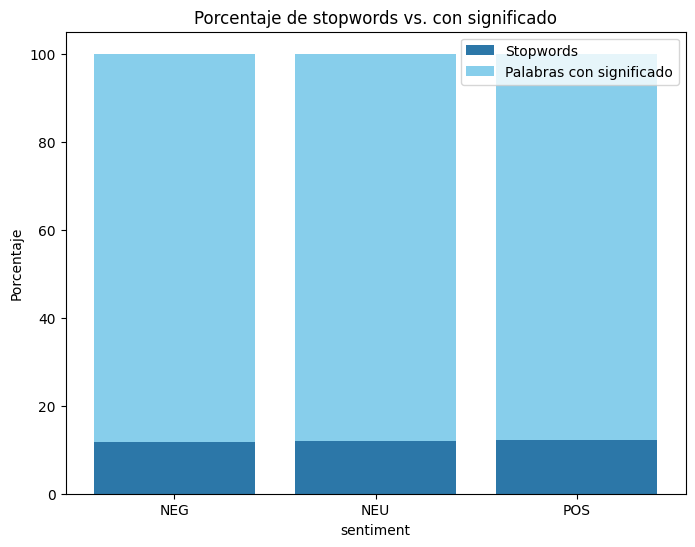

In [102]:
process_text_column2(df, 'review')
graphics_stopwords(df, 'sentiment')

In [103]:
# Definir el patrón para los caracteres especiales
pat = '[{}]'.format(re.escape(string.punctuation))

# Definir la función para normalizar, lematizar y eliminar puntuación
def normalize_document_remove_punct(doc):

    doc = re.sub(r'\d+', '', doc)
    # Separamos en tokens
    tokens = nlp(doc)
    
    # Quitamos puntuación, espacios y stopwords, y aplicamos lematización
    filtered_tokens = [re.sub(pat, ' ', t.lemma_.lower())  # Usamos t.lemma_ para lematizar
                       for t in tokens
                       if not t.is_stop        # Eliminar stopwords
                       and not t.is_punct      # Eliminar puntuación
                       and not t.is_space]      # Eliminar espacios]     
    
    # Juntamos de nuevo en una cadena
    doc = ' '.join(filtered_tokens)
    
    return doc

# Aplicar la función a cada elemento de la columna 'contenido' tanto en treino como en test
df['review'] = df['review'].apply(normalize_document_remove_punct)

df.head(5)

,movie,username,date,score,review,sentiment,stopword_percentage
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313


## Exploratorio

In [104]:
def process_text_column(df, text_column, lemmatizer=None):
    df['tokens'] = df[text_column].apply(nlp)
    return df

In [105]:
process_text_column(df, "review")

,movie,username,date,score,review,sentiment,stopword_percentage,tokens
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000,"(absolutely, brilliant, film, character, deep,..."
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647,"(feel, emotion, long, time, chiron, manifest, ..."
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118,"(movie, masterpiece, deserve, oscar)"
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333,"(refined, production, obvious, weakness, base,..."
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313,"(decent, movie, story, , so, scoring, great,..."
...,...,...,...,...,...,...,...,...
1809,The Ridiculous 6,ultraviper,"Dec 17, 2015",0,watch half hour smirk call comedy hour half fu...,NEG,10.824742,"(watch, half, hour, smirk, call, comedy, hour,..."
1810,The Ridiculous 6,JackKasket,"Dec 15, 2015",0,movie bad review character long review charact...,NEG,10.000000,"(movie, bad, review, character, long, review, ..."
1811,The Ridiculous 6,PicaloJack,"Dec 15, 2015",1,good movie end dog guess sandler write scene d...,NEG,10.221465,"(good, movie, end, dog, guess, sandler, write,..."
1812,The Ridiculous 6,Prosmooth,"Dec 15, 2015",0,adam sandler strip citizenship deport year ago...,NEG,15.315315,"(adam, sandler, strip, citizenship, deport, ye..."


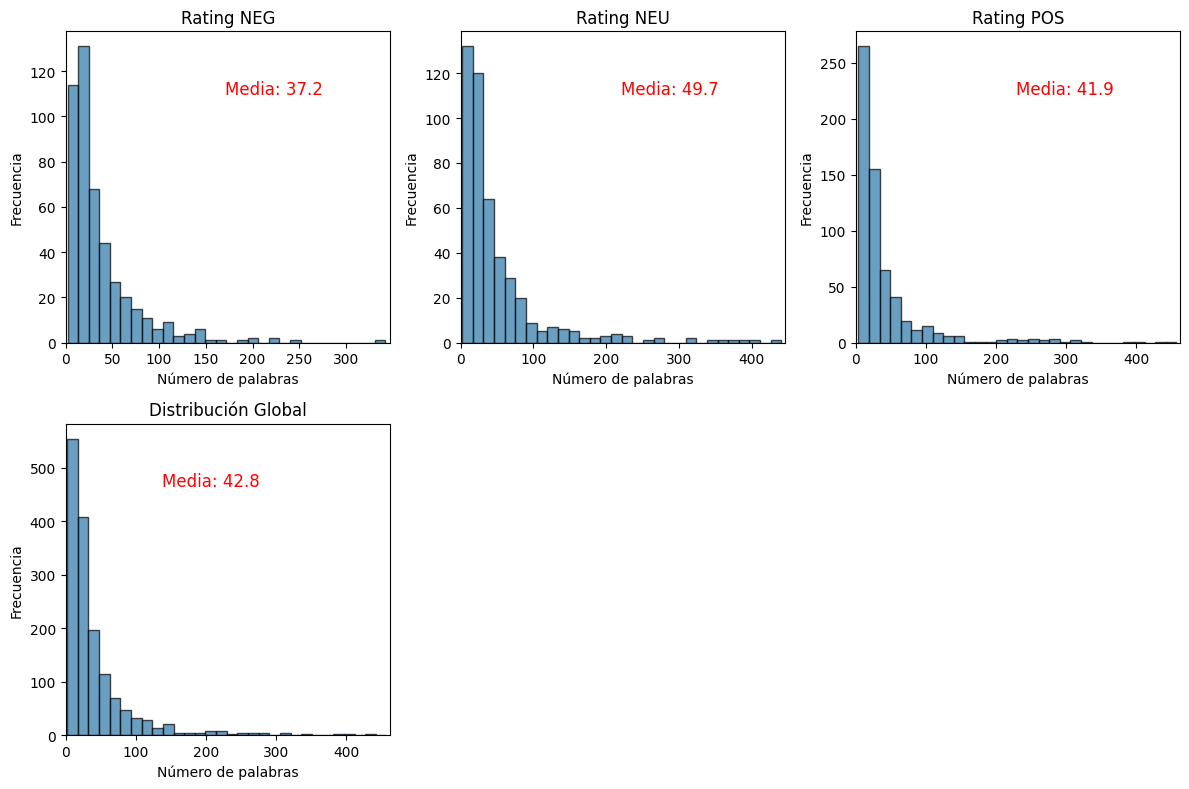

In [106]:
def graficar_longitud_textos(df, text_column, rating_column):
    df['NP'] = df[text_column].apply(len)

    ratings = sorted(df[rating_column].unique())
    num_ratings = len(ratings)
    num_cols = min(3, num_ratings + 1)
    num_rows = (num_ratings + 1 + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = np.ravel(axes)

    for i, rating in enumerate(ratings):
        ax = axes[i]
        subset = df[df[rating_column] == rating]
        media_np = subset['NP'].mean()
        max_np = subset['NP'].max()

        ax.hist(subset['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
        ax.set_xlim(0, max_np + 5)  # Añadimos un margen para mejor visualización
        ax.set_xlabel('Número de palabras')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Rating {rating}')

        ax.text(max_np * 0.5, ax.get_ylim()[1] * 0.8, f'Media: {media_np:.1f}', fontsize=12, color='red')

    # Gráfico global al final
    global_ax = axes[num_ratings]
    media_global = df['NP'].mean()
    max_np_global = df['NP'].max()

    global_ax.hist(df['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
    global_ax.set_xlim(0, max_np_global + 5)
    global_ax.set_xlabel('Número de palabras')
    global_ax.set_ylabel('Frecuencia')
    global_ax.set_title('Distribución Global')
    global_ax.text(max_np_global * 0.3, global_ax.get_ylim()[1] * 0.8, f'Media: {media_global:.1f}', fontsize=12, color='red')

    # Eliminar subplots vacíos si hay
    for j in range(num_ratings + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

graficar_longitud_textos(df, 'tokens', 'sentiment')

In [107]:
df_copy = df.copy()

In [108]:
def eliminar_stopwords(df, column_name):
    # Aplicar eliminación de stopwords a la columna especificada
    df[column_name] = df[column_name].apply(lambda tokens: [word for word in tokens if word not in STOP_WORDS])
    return df

In [109]:
eliminar_stopwords(df_copy, 'tokens')

,movie,username,date,score,review,sentiment,stopword_percentage,tokens,NP
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000,"[absolutely, brilliant, film, character, deep,...",13
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647,"[feel, emotion, long, time, chiron, manifest, ...",24
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118,"[movie, masterpiece, deserve, oscar]",4
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333,"[refined, production, obvious, weakness, base,...",7
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313,"[decent, movie, story, , so, scoring, great,...",11
...,...,...,...,...,...,...,...,...,...
1809,The Ridiculous 6,ultraviper,"Dec 17, 2015",0,watch half hour smirk call comedy hour half fu...,NEG,10.824742,"[watch, half, hour, smirk, call, comedy, hour,...",12
1810,The Ridiculous 6,JackKasket,"Dec 15, 2015",0,movie bad review character long review charact...,NEG,10.000000,"[movie, bad, review, character, long, review, ...",11
1811,The Ridiculous 6,PicaloJack,"Dec 15, 2015",1,good movie end dog guess sandler write scene d...,NEG,10.221465,"[good, movie, end, dog, guess, sandler, write,...",43
1812,The Ridiculous 6,Prosmooth,"Dec 15, 2015",0,adam sandler strip citizenship deport year ago...,NEG,15.315315,"[adam, sandler, strip, citizenship, deport, ye...",18


In [ ]:
def wordclouds(df, column_partition, top_n):

    # Obtener lista de todas las palabras en el dataset
    all_words = [word for tokens in df['tokens'] for word in tokens]

    # Contar frecuencia de palabras
    word_freq = Counter(all_words)

    # Obtener las `top_n` palabras más comunes
    top_words = {word for word, _ in word_freq.most_common(top_n)}

    # Filtrar los tokens eliminando las palabras más comunes
    df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in top_words])

    # Generar WordCloud por cada rating
    ratings = sorted(df[column_partition].unique())
    fig, axes = plt.subplots(1, len(ratings), figsize=(20, 5))

    for i, rating in enumerate(ratings):
        #text = ' '.join([' '.join(tokens) for tokens in df[df[column_partition] == rating]['filtered_tokens']])
        text = ' '.join([' '.join(token.text for token in tokens) for tokens in df[df[column_partition] == rating]['filtered_tokens']])

        wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)

        # Mostrar en subplot
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'{rating}')

    plt.show()


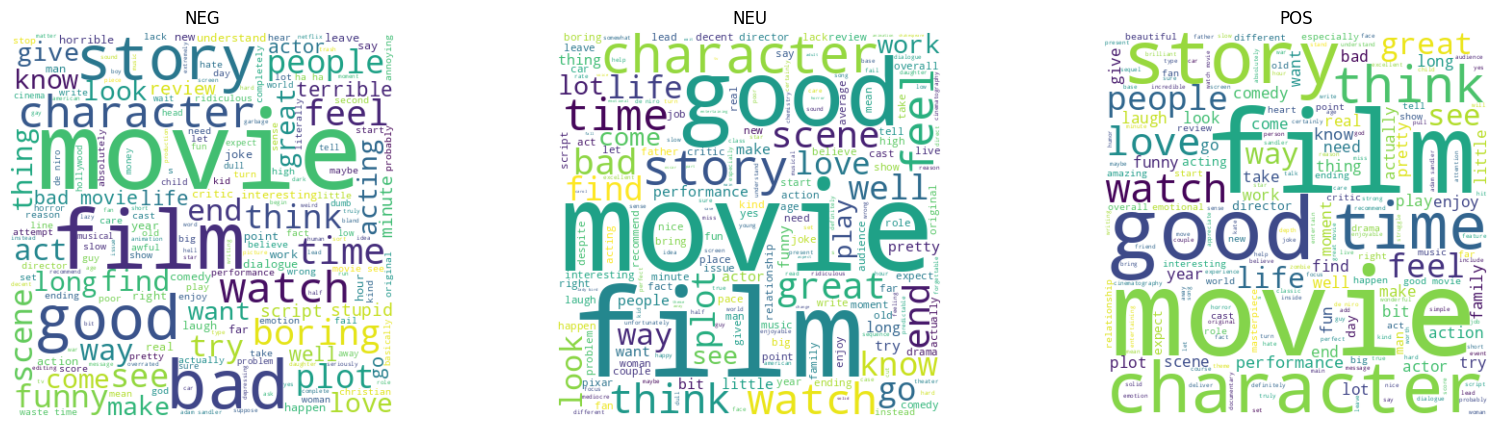

In [111]:
wordclouds(df_copy, 'sentiment', 50)

In [112]:
df['filtered_tokens'] = df['filtered_tokens'].apply(lambda tokens: [token.text for token in tokens])

KeyError: 'filtered_tokens'

In [117]:
# Función para obtener n-gramas
def get_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Función para calcular y graficar bigramas y trigramas más comunes por clases
def plot_most_common_ngrams_by_class(df, text_column, class_column):
    # Crear subgráficos para bigramas
    num_classes = len(df[class_column].unique())
    ncols = 3  # Número de columnas de subgráficos
    nrows = (num_classes + ncols - 1) // ncols  # Calcular número de filas necesarias

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar bigramas
    for i, class_value in enumerate(df[class_column].unique()):

        df['tokens'] = df['tokens'].apply(lambda tokens: [token.text if hasattr(token, "text") else token for token in tokens])

        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular bigramas
        bigram_freq = Counter(get_ngrams(all_words, 2))

        # Obtener los 10 bigramas más comunes
        bigram_most_common = bigram_freq.most_common(10)

        # Bigramas
        bigrams, bigram_counts = zip(*bigram_most_common)
        axes[i].barh(bigrams, bigram_counts, color='#a9dfd0', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Bigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Bigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de bigramas
    plt.tight_layout()
    plt.show()

    # Crear subgráficos para trigramas
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar trigramas
    for i, class_value in enumerate(df[class_column].unique()):
        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular trigramas
        trigram_freq = Counter(get_ngrams(all_words, 3))

        # Obtener los 10 trigramas más comunes
        trigram_most_common = trigram_freq.most_common(10)

        # Trigramas
        trigrams, trigram_counts = zip(*trigram_most_common)
        axes[i].barh(trigrams, trigram_counts, color='#2C77A8', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Trigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Trigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de trigramas
    plt.tight_layout()
    plt.show()

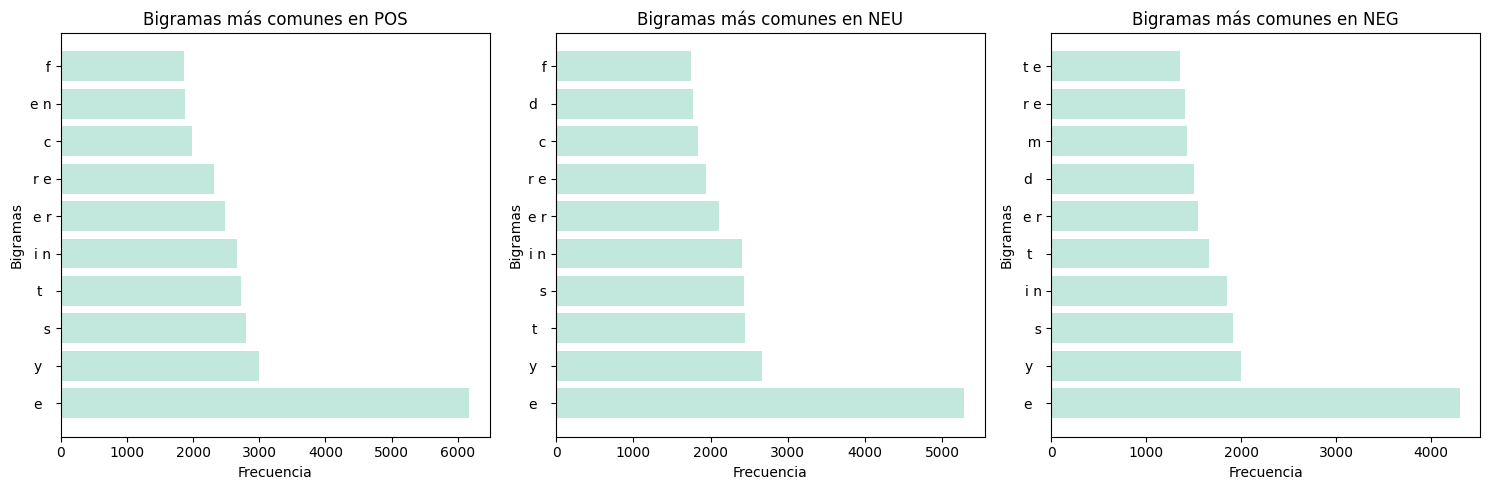

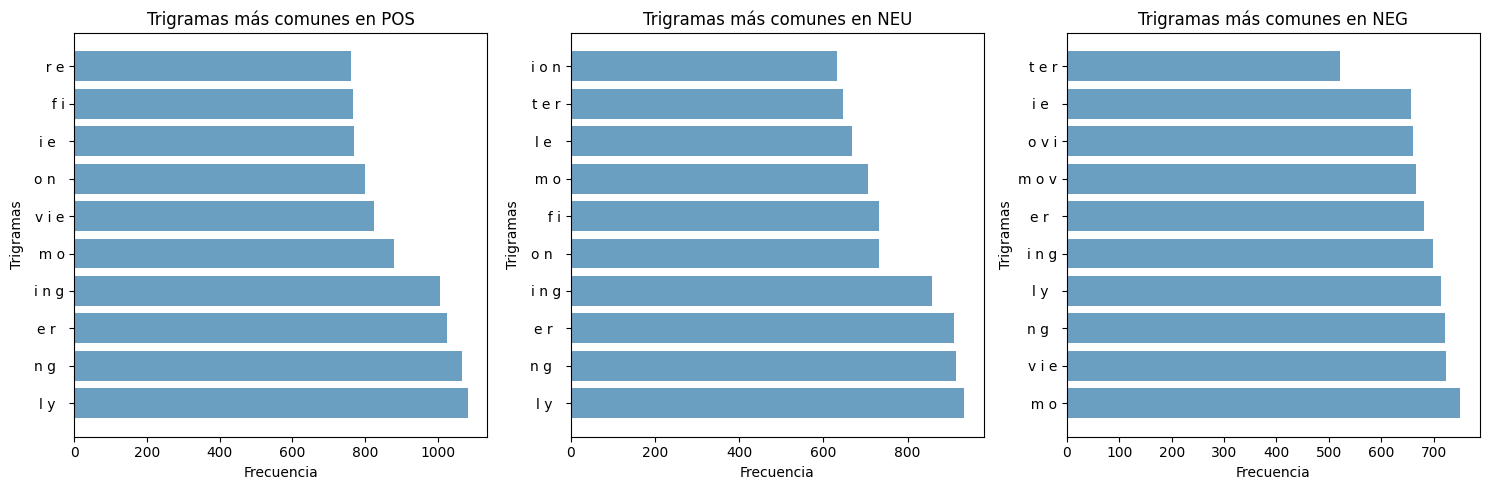

In [118]:
plot_most_common_ngrams_by_class(df, "review", "sentiment")

### Extracción de características 

In [ ]:
from sklearn.model_selection import train_test_split

# Separar para clasificación de sentimiento
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Separar para predicción del score
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review'], df['score'].astype(int), test_size=0.2, random_state=42)

In [ ]:
df['sentiment']

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(df['review'])

print("Número total de palabras únicas:", len(vectorizer.vocabulary_))

In [ ]:
# Ajustar vectorizador solo con los datos de entrenamiento
tfidf = TfidfVectorizer(max_features=3000)
X_train_sent_vec = tfidf.fit_transform(X_train_sent)
X_test_sent_vec = tfidf.transform(X_test_sent)

X_train_score_vec = tfidf.transform(X_train_score)
X_test_score_vec = tfidf.transform(X_test_score)

### Topic modelling

In [ ]:
from sklearn.decomposition import NMF
from scipy.sparse import hstack  # Para concatenar sparse matrices

# Número de temas
n_topics = 20

# Topic modeling con NMF (solo sobre datos de entrenamiento)
nmf = NMF(n_components=n_topics, random_state=42)
W_train_sent = nmf.fit_transform(X_train_sent_vec)  # Representaciones temáticas del train
W_test_sent = nmf.transform(X_test_sent_vec)        # Proyección del test sobre esos mismos temas

W_train_score = nmf.transform(X_train_score_vec)
W_test_score = nmf.transform(X_test_score_vec)

# Concatenar los vectores TF-IDF con las representaciones de tópicos (W matrices)
X_train_sent_topic = hstack([X_train_sent_vec, W_train_sent])
X_test_sent_topic = hstack([X_test_sent_vec, W_test_sent])

X_train_score_topic = hstack([X_train_score_vec, W_train_score])
X_test_score_topic = hstack([X_test_score_vec, W_test_score])

In [ ]:
# Acceder al vocabulario
feature_names = tfidf.get_feature_names_out()

# Función para mostrar las top palabras por cada tópico
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"🔹 Topic {topic_idx}: ", end='')
        top_features_idx = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        print(", ".join(top_features))

# Mostrar los temas
display_topics(nmf, feature_names, no_top_words=10)

#### Embedding preentrenado

In [ ]:
glove_file_path = 'glove.twitter.27B.50d.txt'

# Crear un diccionario vacío para almacenar los embeddings
glove_dict = {}

# Leer el archivo y cargar los embeddings en el diccionario
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Separar cada línea en la palabra y el vector
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = vector

# Verificar que se ha cargado correctamente el diccionario
print(f"Se han cargado {len(glove_dict)} palabras en el diccionario de GloVe.")

In [ ]:
# Función para convertir una reseña en un vector
def text_to_vector(text, glove_dict, dim=50):
    words = text.split()  # Dividir la reseña en palabras (suponiendo que ya están limpias)
    
    # Obtener el vector de cada palabra si está en el diccionario de GloVe
    valid_vectors = [glove_dict[word] for word in words if word in glove_dict]
    
    # Si hay palabras válidas, calcular la media de sus vectores
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        # Si no hay palabras válidas, devolver un vector de ceros
        return np.zeros(dim)

# Aplicar la función a cada reseña en el DataFrame
X_glove = np.vstack(df['review'].apply(lambda x: text_to_vector(x, glove_dict)))

# Verificar la forma de los vectores resultantes
print(X_glove.shape)

In [ ]:
# Para la tarea de clasificación de sentimiento
X_train_glove_sent, X_test_glove_sent, y_train_sent, y_test_sent = train_test_split(
    X_glove, df['sentiment'], test_size=0.2, random_state=42)

# Para la tarea de predicción del score
X_train_glove_score, X_test_glove_score, y_train_score, y_test_score = train_test_split(
    X_glove, df['score'].astype(int), test_size=0.2, random_state=42)

## Modelos

### TF-IDF + LR

#### Clasificación

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_sent_enc = le.fit_transform(y_train_sent)
y_test_sent_enc = le.transform(y_test_sent)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_score_topic, y_train_sent_enc)
prediccion = modelLR.predict(X_test_score_topic)

print('Accuracy (exactitud): ', accuracy_score(y_test_sent_enc, prediccion))

### Embedding preentrenado + LR

In [ ]:
# Crear y entrenar el clasificador
modelLR = LogisticRegression(solver='liblinear')
modelLR.fit(X_train_glove_sent, y_train_sent_enc)

# Realizar predicciones
prediccion = modelLR.predict(X_test_glove_sent)

# Evaluar el modelo
accuracy = accuracy_score(y_test_sent_enc, prediccion)
print('Accuracy (exactitud): ', accuracy)